* Installing necessary packages required

In [6]:
!pip install wget ## for downloading files from web
!pip install transformers ## for transformers

* Importing necessary libraries

In [14]:
import torch
from torch import nn
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## checking for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use {device}")

Device in use cuda


## Downloading and pre-processing the Data
Dataset used is MIT Movie Corpus

In [5]:
train_data_url = 'https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio'
test_data_url = 'https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio'

In [8]:
import wget
import os

In [12]:
wget.download(test_data_url)

'engtest.bio'

In [13]:
wget.download(train_data_url)

'engtrain.bio'

In [24]:
## Need to extract data from this .bio format

sentences = []
labels = []

tokens = []
token_labels = []
unique_labels = set()


In [25]:
with open("./engtrain.bio", newline = '') as lines:

    line_reader = csv.reader(lines, delimiter='\t')
    cnt = 10
    for line in line_reader:
        if cnt > 0:
          cnt -= 1
          print(f'Line : {line}')
          if line != []:
            tokens.append(line[1])
            token_labels.append(line[0])
            unique_labels.add(line[0])

Line : ['O', 'what']
Line : ['O', 'movies']
Line : ['O', 'star']
Line : ['B-ACTOR', 'bruce']
Line : ['I-ACTOR', 'willis']
Line : []
Line : ['O', 'show']
Line : ['O', 'me']
Line : ['O', 'films']
Line : ['O', 'with']


In [19]:
## now we can clearly see that Line[0] contains labels and Line[1] contains word or say token
## also in line 6 it is empty list that means end of a sentence so, we need to store token of sentence above it and its labels into another list

In [26]:
def get_sentences_and_labels(file_path):
  sentences = []
  labels = []

  tokens = []
  token_labels = []
  unique_labels = set()

  with open(file_path, newline = '') as lines:
    line_reader = csv.reader(lines, delimiter='\t')
    for line in line_reader:
        if line == []:
            sentences.append(tokens)
            labels.append(token_labels)

            tokens = []
            token_labels = []
        else:
            tokens.append(line[1])
            token_labels.append(line[0])

            unique_labels.add(line[0])

  return sentences, labels, unique_labels

In [28]:
## extracting sentences and corresponding labels for training dataset and testing dataset
train_sentences, train_labels, train_unique_labels = get_sentences_and_labels("./engtrain.bio")
test_sentences, test_labels, test_unique_labels = get_sentences_and_labels("./engtest.bio")

In [33]:
## lets take a view
train_sentences[1]

['show', 'me', 'films', 'with', 'drew', 'barrymore', 'from', 'the', '1980s']

In [34]:
train_labels[1]

['O', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'O', 'B-YEAR']

In [32]:
## joining words in a sentence
' '.join(train_sentences[1])

'show me films with drew barrymore from the 1980s'

In [35]:
print(f"Number of sentences in training set : {len(train_sentences)}")
print(f"Number of sentences in testing set : {len(test_sentences)}")

Number of sentences in training set : 9775
Number of sentences in testing set : 2443


Preparing input text data for Feeding it into BERT model by converting and spilting the text into tokens and mapping the tokens using BertTokenizer function

In [36]:
from transformers import BertTokenizer
import numpy as np
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [37]:
## lets try out the tokenizer with 1st sentence of training data
tokenizer.encode(train_sentences[1])

[101, 1437, 1143, 2441, 1114, 3583, 100, 1121, 1103, 3011, 102]

In [39]:
## lets decode it back
tokenizer.decode([101, 1437, 1143, 2441, 1114, 3583, 100, 1121, 1103, 3011, 102])

'[CLS] show me films with drew [UNK] from the 1980s [SEP]'

Calculating of length of each tokenized sentences

In [40]:
token_lengths = []

for sentence in train_sentences:
  joined_sentence = ' '.join(sentence)
  encoding = tokenizer.encode(joined_sentence, add_special_tokens=True)
  token_lengths.append(len(encoding))

In [41]:
print(f'Minimum  length: {min(token_lengths)} tokens')
print(f'Maximum length: {max(token_lengths)} tokens')
print(f'Median length: {int(np.median(token_lengths))} tokens')

Minimum  length: 3 tokens
Maximum length: 59 tokens
Median length: 14 tokens


<ipython-input-43-87f0b573b861>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lengths, kde=False, rug=False,color='plum')


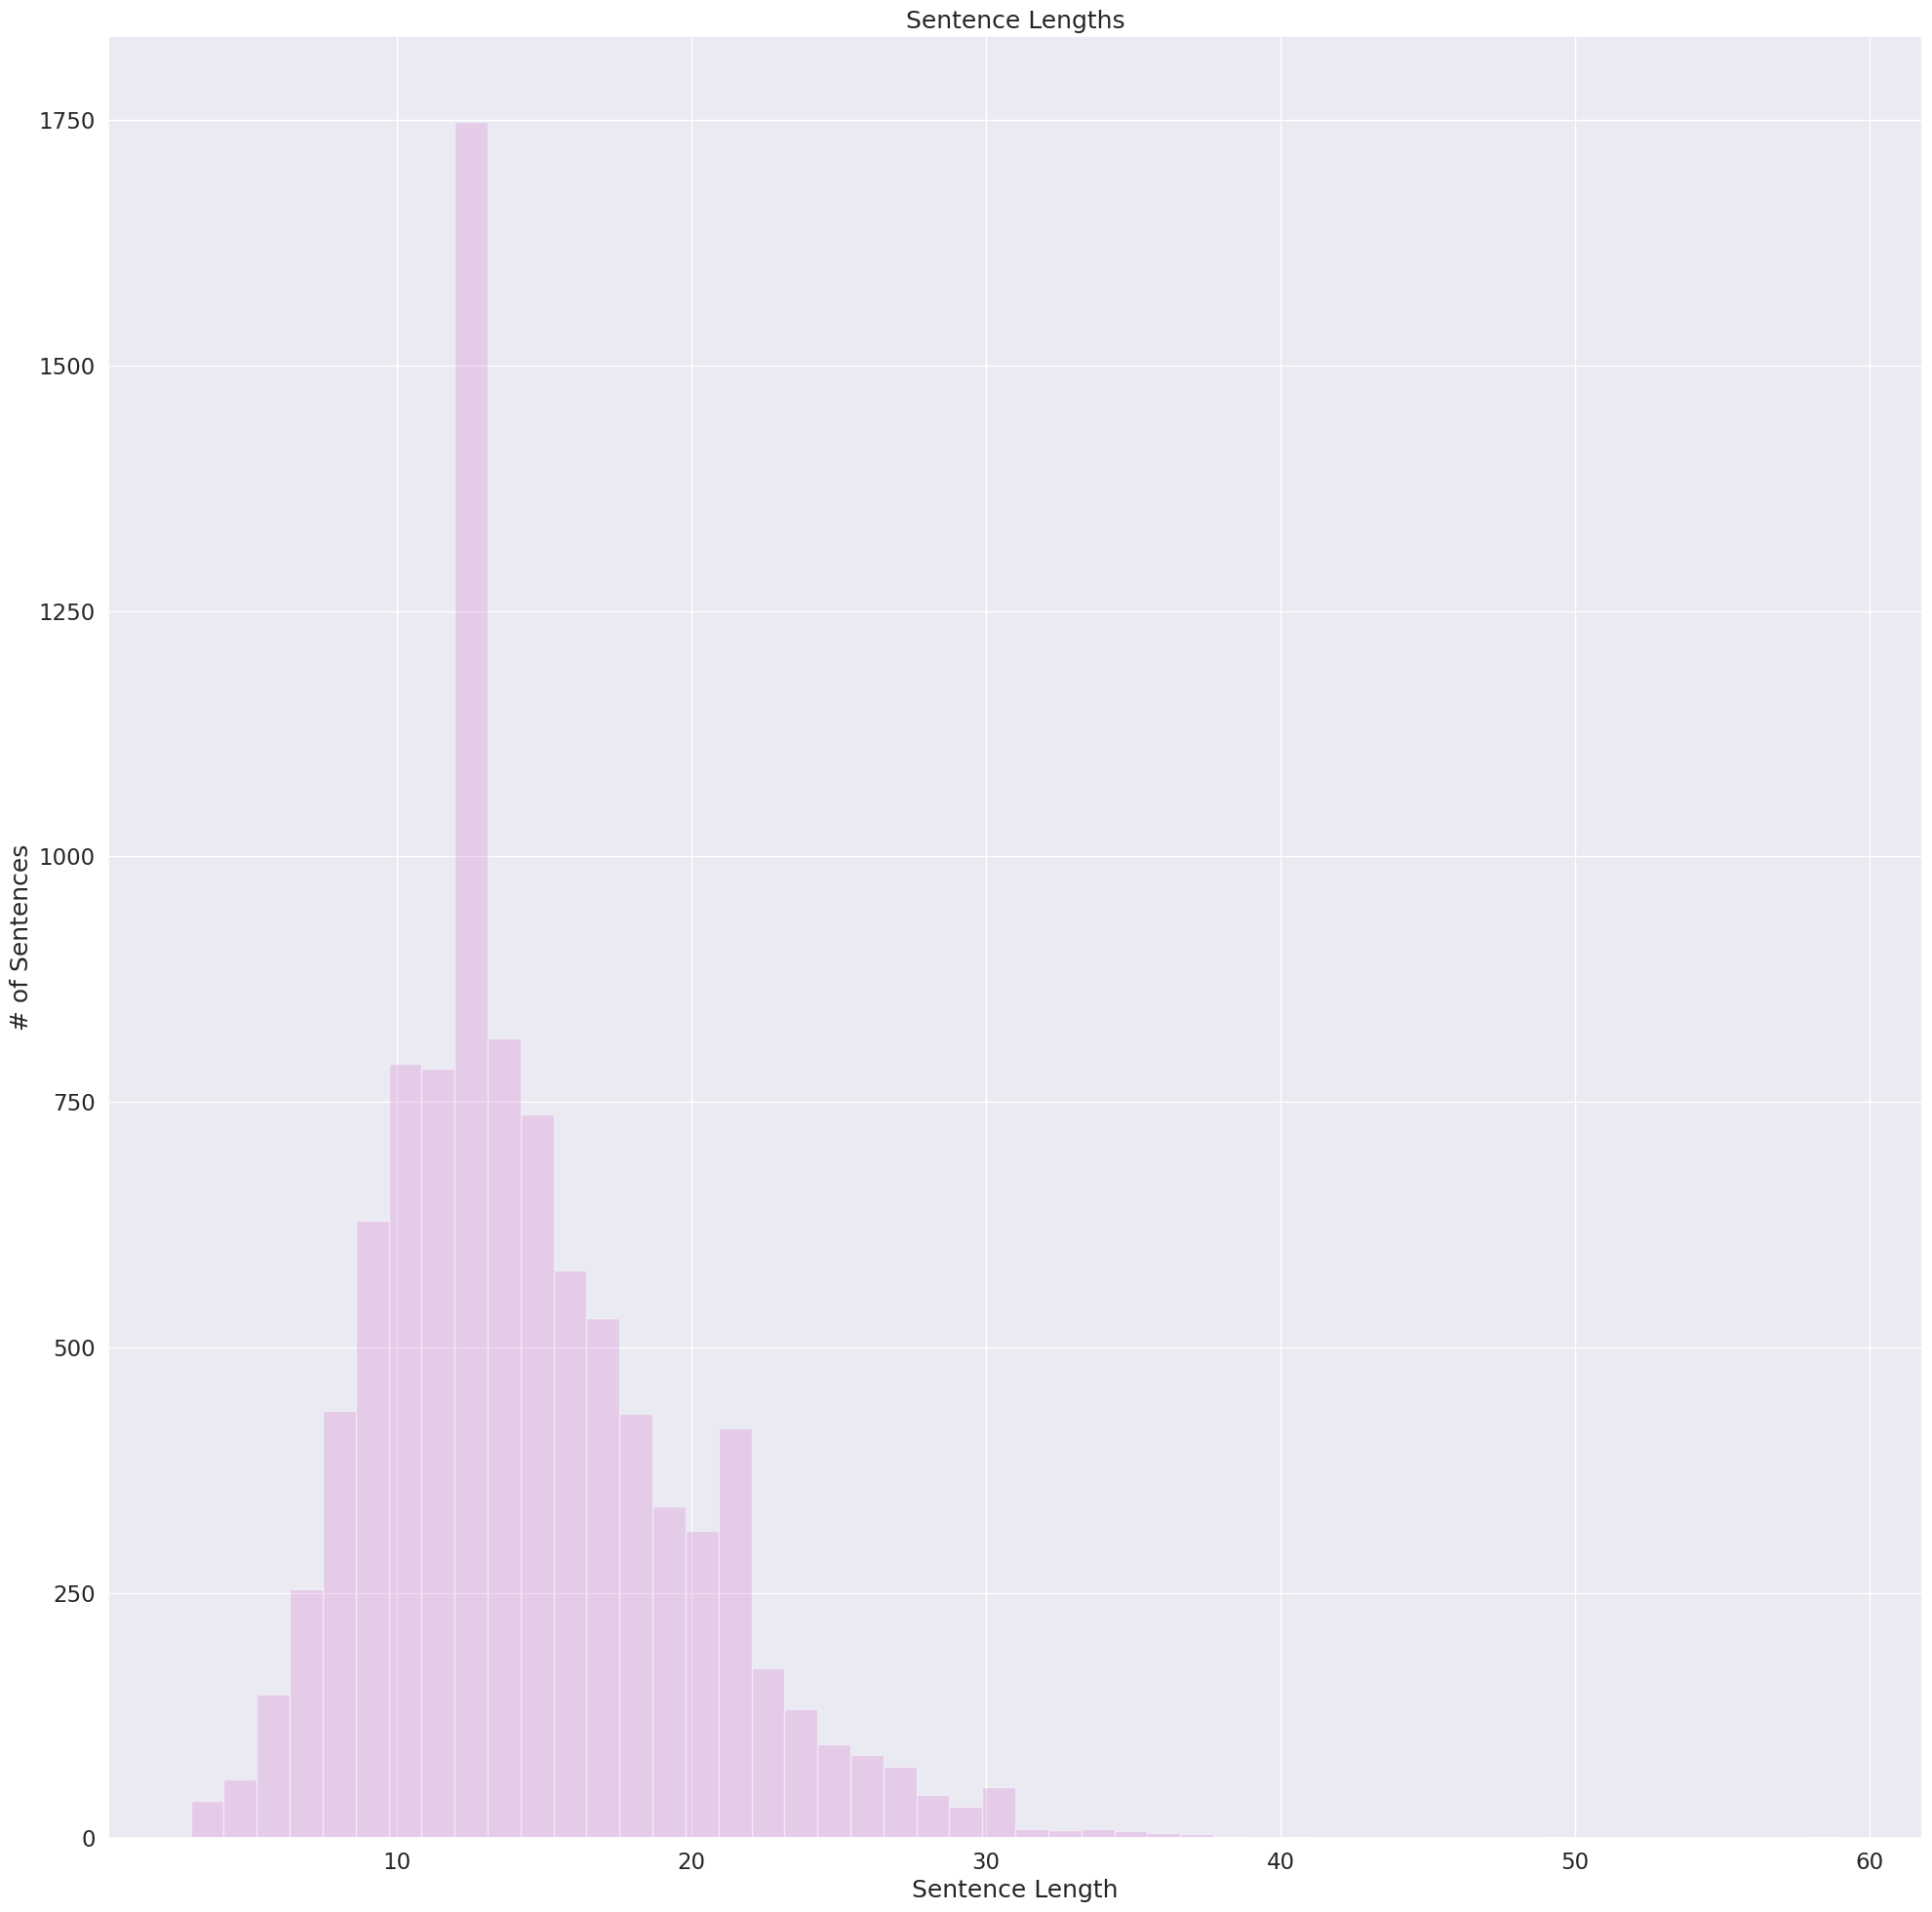

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.figure(figsize=(24,24))
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(token_lengths, kde=False, rug=False,color='plum')

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences');

Now we must include Padding [PAD] token in the input so every tokens should be of same length. We have selected max length of PAD token to be 59 (as max is 59)

In [52]:
## trying it on sample sentence

joined_sentence = ' '.join(train_sentences[1])
sample = tokenizer.encode_plus(joined_sentence, add_special_tokens=True, truncation=True, max_length=59, padding=True, pad_to_max_length = True, return_attention_mask=True, return_tensors='pt')
## return tensor = 'pt' to return tensor as per pytorch framework
print(sample)

{'input_ids': tensor([[ 101, 1437, 1143, 2441, 1114, 3583, 2927, 1616, 4982, 1121, 1103, 3011,
          102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2783: UserWarning: Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.
  warnings.warn("Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.")


Mapping labels

In [62]:
label_map = {}

for (i, label) in enumerate(train_unique_labels):
  label_map[label] = i

print(label_map)

{'B-ACTOR': 0, 'B-CHARACTER': 1, 'I-CHARACTER': 2, 'I-SONG': 3, 'B-SONG': 4, 'B-TRAILER': 5, 'B-RATING': 6, 'B-REVIEW': 7, 'B-GENRE': 8, 'I-ACTOR': 9, 'O': 10, 'I-YEAR': 11, 'I-TRAILER': 12, 'I-RATING': 13, 'B-DIRECTOR': 14, 'I-TITLE': 15, 'B-YEAR': 16, 'I-DIRECTOR': 17, 'B-RATINGS_AVERAGE': 18, 'B-PLOT': 19, 'B-TITLE': 20, 'I-GENRE': 21, 'I-RATINGS_AVERAGE': 22, 'I-REVIEW': 23, 'I-PLOT': 24}


## Adding attention mask

In [63]:
def get_input_ids_and_attention_mask(sentences):
  input_ids = []
  attention_masks = []
  for sentence in sentences:
    joined_sentence = ' '.join(sentence)
    encoding = tokenizer.encode_plus(joined_sentence, add_special_tokens=True, truncation=True, max_length=59, pad_to_max_length = True, return_attention_mask=True, return_tensors='pt')
    input_ids.append(encoding['input_ids'][0])
    attention_masks.append(encoding['attention_mask'][0])
  return input_ids, attention_masks

In [64]:
train_input_ids, train_attention_mask = get_input_ids_and_attention_mask(train_sentences)
test_input_ids, test_attention_mask = get_input_ids_and_attention_mask(test_sentences)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [65]:
print('Original: ', train_sentences[24])
print('Token IDs:', train_input_ids[24])
print('Masks:', train_attention_mask[24])

Original:  ['find', 'the', 'movies', 'action', 'movies', 'directed', 'by', 'john', 'woo', 'from', 'the', '1990s']
Token IDs: tensor([  101,  1525,  1103,  5558,  2168,  5558,  2002,  1118,   179, 10559,
         1179,   192,  5658,  1121,  1103,  3281,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Adding labels to null tokens

In [84]:
def get_padded_labels(input_ids, labels):

  new_labels = []

  # The special label ID we'll give to "extra" tokens.
  null_label_id = -100

  for (sen, orig_labels) in zip(input_ids, labels):
      padded_labels = []
      orig_labels_i = 0

      for token_id in sen:
          token_id = token_id.numpy().item()

          if (token_id == tokenizer.pad_token_id) or \
              (token_id == tokenizer.cls_token_id) or \
              (token_id == tokenizer.sep_token_id):
              padded_labels.append(null_label_id)

          elif tokenizer.ids_to_tokens[token_id][0:2] == '##':
              padded_labels.append(null_label_id)

          else:
              label_str = orig_labels[orig_labels_i]
              padded_labels.append(label_map[label_str])
              orig_labels_i += 1

      assert(len(sen) == len(padded_labels))
      new_labels.append(padded_labels)

  return new_labels

In [85]:
train_input_ids[0]

tensor([  101,  1184,  5558,  2851,  9304, 15776,  1209,  1548,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])

In [86]:
train_labels[0]

['O', 'O', 'O', 'B-ACTOR', 'I-ACTOR']

In [87]:
new_train_labels = get_padded_labels(train_input_ids, train_labels)

In [88]:
print('\nSentence:    ', train_sentences[2])
print('\nLabels:      ', train_labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(train_sentences[2])))
print('\nToken IDs:   ', train_input_ids[2])
print('\nNew Labels:  ', new_train_labels[2])
print('\nMask:        ', train_attention_mask[2])


Sentence:     ['what', 'movies', 'starred', 'both', 'al', 'pacino', 'and', 'robert', 'deniro']

Labels:       ['O', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'B-ACTOR', 'I-ACTOR']

BERT Tokens:  ['what', 'movies', 'starred', 'both', 'al', 'p', '##ac', '##ino', 'and', 'robe', '##rt', 'den', '##iro']

Token IDs:    tensor([  101,  1184,  5558,  4950,  1241,  2393,   185,  7409,  4559,  1105,
        11580,  3740, 10552,  9992,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])

New Labels:   [-100, 10, 10, 10, 10, 0, 9, -100, -100, 10, 0, -100, 9, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 

In [91]:
pt_input_ids = torch.stack(train_input_ids, dim=0)
pt_attention_masks = torch.stack(train_attention_mask, dim=0)
pt_labels = torch.tensor(new_train_labels, dtype=torch.long)

In [92]:
pt_input_ids.shape

torch.Size([9775, 59])

In [93]:
pt_labels.shape

torch.Size([9775, 59])

In [95]:
pt_attention_masks.shape

torch.Size([9775, 59])

In [96]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,797 training samples
  978 validation samples


In [97]:
## Making DataLoader for training and evaluation
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

In [100]:
print(len(label_map))

25


Using 12 Layer BERT Model for out task

The core of the BERT model consists of 12 Transformer encoder layers. Each layer includes:

Multi-Head Self-Attention: This mechanism allows the model to focus on different parts of the input sequence when computing the representation for each token.
Feed-Forward Neural Network: A fully connected network that applies non-linear transformations to the input.
Layer Normalization and Residual Connections: These are used to stabilize training and allow gradients to flow through the network.
The output from each layer is a new set of token representations, which are refined and contextualized at each layer.

In [98]:
from transformers import BertForTokenClassification, AdamW, BertConfig
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels = len(label_map) + 1, output_attentions = False, output_hidden_states = False)
model.cuda()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [101]:
# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [102]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## Training

In [103]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [104]:
loss_values = []

In [105]:
for epoch_i in range(0, epochs):

    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))

======== Epoch 1 / 4 ========
Training...
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.77
======== Epoch 2 / 4 ========
Training...
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.33
======== Epoch 3 / 4 ========
Training...
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.24
======== Epoch 4 / 4 ========
Training...
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.18


<function matplotlib.pyplot.show(close=None, block=None)>

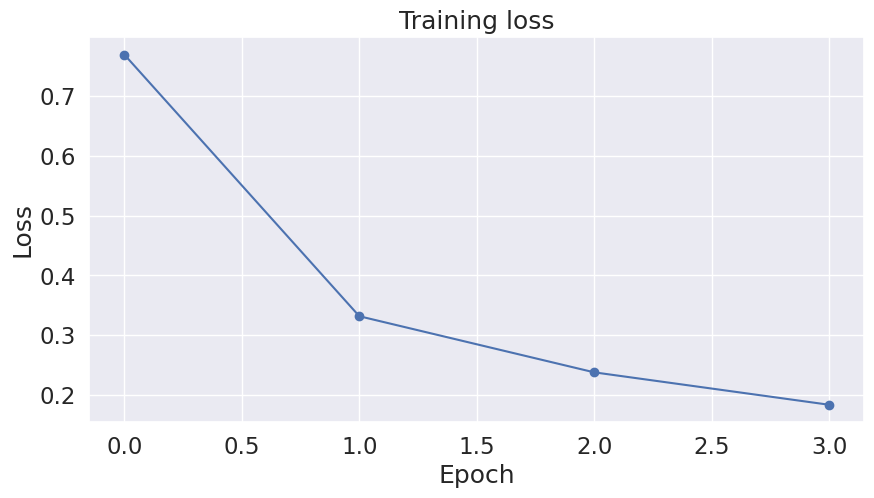

In [106]:
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show

## Preparing the test data

In [107]:
test_sentences, test_labels, test_unique_labels = get_sentences_and_labels("./engtest.bio")

In [108]:
test_input_ids, test_attention_mask = get_input_ids_and_attention_mask(test_sentences)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [112]:
print('Original: ', test_sentences[0])
print('Token IDs:', test_input_ids[0])
print('Masks:', test_attention_mask[0])

Original:  ['are', 'there', 'any', 'good', 'romantic', 'comedies', 'out', 'right', 'now']
Token IDs: tensor([  101,  1132,  1175,  1251,  1363,  6376, 25795,  1149,  1268,  1208,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [113]:
## making new test labels
new_test_labels = get_padded_labels(test_input_ids, test_labels)

In [114]:
print('\nSentence:    ', test_sentences[2])
print('\nLabels:      ', test_labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(test_sentences[2])))
print('\nToken IDs:   ', test_input_ids[2])
print('\nNew Labels:  ', new_test_labels[2])
print('\nMask:        ', test_attention_mask[2])


Sentence:     ['list', 'the', 'five', 'star', 'rated', 'movies', 'starring', 'mel', 'gibson']

Labels:       ['O', 'O', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR']

BERT Tokens:  ['list', 'the', 'five', 'star', 'rated', 'movies', 'starring', 'me', '##l', 'g', '##ib', '##son']

Token IDs:    tensor([  101,  2190,  1103,  1421,  2851,  6317,  5558,  3937,  1143,  1233,
          176, 13292,  2142,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])

New Labels:   [-100, 10, 10, 18, 22, 10, 10, 10, 0, -100, 9, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100

In [116]:
pt_input_ids = torch.stack(test_input_ids, dim=0)
pt_attention_masks = torch.stack(test_attention_mask, dim=0)
pt_labels = torch.tensor(new_test_labels, dtype=torch.long)

In [117]:
batch_size = 32

prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [118]:
print(f"Total sentences in test data : {len(test_sentences)}")

Total sentences in test data : 2443


Prediction on test set

In [119]:
# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


Calculating the F1-score

In [120]:
from sklearn.metrics import f1_score

In [123]:
len(predictions[0])

32

In [124]:
# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

In [125]:
print(f'Shape of all predictions : {all_predictions.shape}')
print(f'Shape of all true labels : {all_true_labels.shape}')

Shape of all predictions : (2443, 59, 26)
Shape of all true labels : (2443, 59)


In [127]:
# Next, let's remove the third dimension (axis 2), which has the scores
# for all 18 labels.

# For each token, pick the label with the highest score.
predicted_label_ids = np.argmax(all_predictions, axis=2)

In [128]:
print("\nAfter choosing the highest scoring label for each token:")
print("    ", predicted_label_ids.shape)


After choosing the highest scoring label for each token:
     (2443, 59)


In [129]:
# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

In [130]:
print("\nAfter flattening the sentences, we have predictions:")
print("    ", predicted_label_ids.shape)
print("and ground truth:")
print("    ", all_true_labels.shape)


After flattening the sentences, we have predictions:
     (144137,)
and ground truth:
     (144137,)


In [131]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []
real_token_labels = []

# For each of the input tokens in the dataset...
for i in range(len(all_true_labels)):

    # If it's not a token with a null label...
    if not all_true_labels[i] == -100:

        # Add the prediction and the ground truth to their lists.
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print(" After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))

Before filtering out `null` tokens, length = 144,137
 After filtering out `null` tokens, length = 24,686


In [132]:
from sklearn.metrics import f1_score

f1 = f1_score(real_token_labels, real_token_predictions, average='micro')

print ("F1 score: {:.2%}".format(f1))

F1 score: 92.24%


Testing

In [133]:
test_sentence = input ("Enter number :")

Enter number :Characterized by its use of Technicolor, fantasy storytelling, musical score, and memorable characters, the film has become an American pop culture icon. It was nominated for six Academy Awards, including Best Picture, but lost to Gone with the Wind, also directed by Fleming.


In [134]:
#Encoding and convert the sentences into tensors
sample_sentence = tokenizer.encode(test_sentence)
sample_input_ids = torch.tensor([sample_sentence]).cuda()

#Predicting the test data set using model() function
with torch.no_grad():
    output = model(sample_input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

#Function which retrieves key value for our Label Dictionary
def get_key(val):
    for key, value in label_map.items():
         if val == value:
             return key

    return "key doesn't exist"

#Tokenize
tokens = tokenizer.convert_ids_to_tokens(sample_input_ids.to('cpu').numpy()[0])
new_tokens, new_label = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_label.append(get_key(label_idx))
        new_tokens.append(token)

#Appending Tokens and Labels
movie_token=[]
movie_label=[]
for token, label in zip(new_tokens, new_label):
    movie_token.append(token)
    movie_label.append(label)

df=pd.DataFrame({"Token":movie_token,"Movie_Label":movie_label})

In [135]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
Token,[CLS],Characterized,by,its,use,of,Technicolor,",",fantasy,storytelling,...,with,the,Wind,",",also,directed,by,Fleming,.,[SEP]
Movie_Label,O,O,O,O,O,O,B-RATINGS_AVERAGE,I-DIRECTOR,B-GENRE,I-PLOT,...,O,O,O,O,O,O,O,B-DIRECTOR,I-DIRECTOR,I-RATING


Saving the model

In [136]:
import joblib
filename = 'Finetuned_BERT_NER.h5'
joblib.dump(model, filename)

['Finetuned_BERT_NER.h5']